In [1]:
!pip install faiss-cpu --quiet


In [2]:
# ===========================================
# 1. Importación de librerías
# ===========================================
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from sklearn.pipeline import Pipeline as SKPipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, f1_score, roc_auc_score,
    RocCurveDisplay, confusion_matrix, make_scorer
)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN


In [3]:
# ===========================================
# 2. Carga de datos y preprocesamiento
# ===========================================
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
X = df.drop(columns="incumplimiento_credito")
y = df["incumplimiento_credito"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.20, stratify=y, random_state=42
)

numeric_cols     = [c for c in X.columns if X[c].dtype != "object"]
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]

preprocessor = ColumnTransformer([
    ("num", SKPipeline([("scaler", StandardScaler())]), numeric_cols),
    ("cat", SKPipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]), categorical_cols)
])

In [4]:
# ===========================================
# 3. Pipelines balanceados
# ===========================================
knn = KNeighborsClassifier()

pipelines = {
    "SMOTE": ImbPipeline([
        ("pre", deepcopy(preprocessor)),
        ("over", SMOTE(random_state=42)),
        ("clf", KNeighborsClassifier())
    ]),
    "ADASYN": ImbPipeline([
        ("pre", deepcopy(preprocessor)),
        ("over", ADASYN(random_state=42)),
        ("clf", KNeighborsClassifier())
    ])
}

## KD TREE

In [5]:
# ===========================================
# 4. GridSearchCV (recall sobre clase 1)
# ===========================================
param_grid = {
    "clf__n_neighbors": [3, 5, 10, 15, 20, 25, 30],               # Más granularidad
    "clf__weights": ["uniform", "distance"],
    "clf__algorithm": ["kd_tree"],
    "clf__leaf_size": [10, 20, 30, 40, 50, 60]
}

recall1_scorer = make_scorer(recall_score, pos_label=1)
scoring = {
    "recall1": recall1_scorer,
    "accuracy": "accuracy",
    "roc_auc": "roc_auc"
}

grids = {
    name: GridSearchCV(
        pipe, param_grid=param_grid,
        scoring=scoring, refit="recall1",
        cv=3, n_jobs=24, verbose=0
    )
    for name, pipe in pipelines.items()
}

In [6]:
# ===========================================
# 5. Entrenamiento
# ===========================================
results_kd = {}
for name, grid in grids.items():
    print(f"Entrenando → {name}")
    t0 = time.time()
    grid.fit(X_train, y_train)
    fit_minutes = (time.time() - t0) / 60
    best_pipe = grid.best_estimator_

    y_prob = best_pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    results_kd[f"{name}_kd"] = {

        "best_params": grid.best_params_,
        "estimator": best_pipe,
        "y_prob": y_prob,
        "y_pred": y_pred,
        "fit_minutes": fit_minutes,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall1": recall_score(y_test, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob)
    }

Entrenando → SMOTE
Entrenando → ADASYN


In [7]:
# Métricas
df_metrics_kd = pd.DataFrame(results_kd).T[
    ["Precision", "Recall1", "Accuracy", "F1", "AUC", "fit_minutes"]
].rename(columns={"fit_minutes": "Time (min)"})

styled = (
    df_metrics_kd.style
        .format("{:.4f}", subset=df_metrics_kd.columns[:-1])
        .format("{:.2f}", subset=["Time (min)"])
        .highlight_max(axis=0, subset=["Recall1"], color="lightgreen")
        .set_caption("Métricas KNN para algoritmo kd_tree (mejor Recall en verde)")
)
display(styled)

# Hiperparámetros óptimos
pd.DataFrame({k: v["best_params"] for k, v in results_kd.items()})

,Precision,Recall1,Accuracy,F1,AUC,Time (min)
SMOTE_kd,0.1041,0.8441,0.3659,0.1854,0.6458,390.72
ADASYN_kd,0.1029,0.8561,0.3501,0.1838,0.6433,362.73


,SMOTE_kd,ADASYN_kd
clf__algorithm,kd_tree,kd_tree
clf__leaf_size,10,10
clf__n_neighbors,30,30
clf__weights,distance,distance


## Ball Tree

In [8]:
# ===========================================
# 4. GridSearchCV (recall sobre clase 1)
# ===========================================
param_grid_bt = {
    "clf__n_neighbors": [3, 5, 10, 15, 20, 25, 30],               # Más granularidad
    "clf__weights": ["uniform", "distance"],
    "clf__algorithm": ["ball_tree"],
    "clf__leaf_size": [10, 20, 30, 40, 50, 60]
}

recall1_scorer = make_scorer(recall_score, pos_label=1)
scoring = {
    "recall1": recall1_scorer,
    "accuracy": "accuracy",
    "roc_auc": "roc_auc"
}

grids = {
    name: GridSearchCV(
        pipe, param_grid=param_grid_bt,
        scoring=scoring, refit="recall1",
        cv=3, n_jobs=24, verbose=0
    )
    for name, pipe in pipelines.items()
}

In [9]:
# ===========================================
# 5. Entrenamiento
# ===========================================
results_bt = {}
for name, grid in grids.items():
    print(f"Entrenando → {name}")
    t0 = time.time()
    grid.fit(X_train, y_train)
    fit_minutes = (time.time() - t0) / 60
    best_pipe = grid.best_estimator_

    y_prob = best_pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    results_bt[f"{name}_ball"] = {
        "best_params": grid.best_params_,
        "estimator": best_pipe,
        "y_prob": y_prob,
        "y_pred": y_pred,
        "fit_minutes": fit_minutes,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall1": recall_score(y_test, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob)
    }

Entrenando → SMOTE
Entrenando → ADASYN


In [10]:
# Métricas
df_metrics_bt = pd.DataFrame(results_bt).T[
    ["Precision", "Recall1", "Accuracy", "F1", "AUC", "fit_minutes"]
].rename(columns={"fit_minutes": "Time (min)"})

styled = (
    df_metrics_bt.style
        .format("{:.4f}", subset=df_metrics_bt.columns[:-1])
        .format("{:.2f}", subset=["Time (min)"])
        .highlight_max(axis=0, subset=["Recall1"], color="lightgreen")
        .set_caption("Métricas KNN par algoritmo ball tree (mejor Recall en verde)")
)
display(styled)

# Hiperparámetros óptimos
pd.DataFrame({k: v["best_params"] for k, v in results_bt.items()})

,Precision,Recall1,Accuracy,F1,AUC,Time (min)
SMOTE_ball,0.1041,0.8441,0.3659,0.1854,0.6458,369.49
ADASYN_ball,0.1029,0.8561,0.3501,0.1838,0.6433,322.39


,SMOTE_ball,ADASYN_ball
clf__algorithm,ball_tree,ball_tree
clf__leaf_size,10,10
clf__n_neighbors,30,30
clf__weights,distance,distance


## FAISS

In [11]:
import time
import faiss

results = {}  # inicializar diccionario

# Paso 1: escalar
X_tr = StandardScaler().fit_transform(X_train.select_dtypes(include=np.number))
X_te = StandardScaler().fit_transform(X_test.select_dtypes(include=np.number))
y_tr = y_train.reset_index(drop=True)

# Paso 2: FAISS index
index = faiss.IndexFlatL2(X_tr.shape[1])
index.add(X_tr)

# Paso 3: evaluar por k
k_values = [3, 5, 10, 15, 20, 25, 30]
faiss_results = {}

for k in k_values:
    D, I = index.search(X_te, k)
    y_pred = [int(np.sum(y_tr.iloc[vecinos]) >= (k / 2)) for vecinos in I]
    y_prob = [np.mean(y_tr.iloc[vecinos]) for vecinos in I]

    faiss_results[k] = {
        "k": k,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall1": recall_score(y_test, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob)
    }

# Paso 4: guardar el mejor
best_k = max(faiss_results, key=lambda k: faiss_results[k]["Recall1"])
best_res = faiss_results[best_k]

# Guardar FAISS para SMOTE y ADASYN (misma predicción pero diferente balanceador previo)
for bal in ["SMOTE", "ADASYN"]:
    results[f"{bal}_faiss"] = {
        "best_params": {"k": best_k, "distance": "L2"},
        "estimator": f"faiss_manual_k={best_k}",
        "y_pred": np.array(best_res["y_pred"]),
        "y_prob": np.array(best_res["y_prob"]),
        "fit_minutes": 0,
        "Precision": best_res["Precision"],
        "Recall1": best_res["Recall1"],
        "Accuracy": best_res["Accuracy"],
        "F1": best_res["F1"],
        "AUC": best_res["AUC"]
    }


In [12]:
# Filtrar solo SMOTE y ADASYN del diccionario results
resultados_balanceo = {k: v for k, v in results.items() if "SMOTE" in k or "ADASYN" in k}


# Crear DataFrame
df_balanceo = (
    pd.DataFrame(resultados_balanceo)
    .T[["Precision", "Recall1", "Accuracy", "F1", "AUC", "fit_minutes"]]
    .rename(columns={"fit_minutes": "Time (min)"})
)

# Estilo visual
styled_balanceo = (
    df_balanceo.style
        .format("{:.4f}", subset=df_balanceo.columns[:-1])
        .format("{:.2f}", subset=["Time (min)"])
        .highlight_max(subset=["Recall1"], color="lightgreen")
        .set_caption("Métricas KNN para técnicas de balanceo: SMOTE vs ADASYN")
)
display(styled_balanceo)


,Precision,Recall1,Accuracy,F1,AUC,Time (min)
SMOTE_faiss,0.1923,0.0522,0.9002,0.0821,0.5568,0.00
ADASYN_faiss,0.1923,0.0522,0.9002,0.0821,0.5568,0.00


In [13]:
print("Valores óptimos de k por modelo:\n")
for modelo, valores in resultados_balanceo.items():
    k_optimo = valores["best_params"].get("k") or valores["best_params"].get("clf__n_neighbors")
    print(f"{modelo}: k = {k_optimo}")


Valores óptimos de k por modelo:

SMOTE_faiss: k = 3
ADASYN_faiss: k = 3


In [14]:
results_completo = {
    **results_kd,     # contiene claves como 'SMOTE_kd', 'ADASYN_kd'
    **results_bt,     # contiene claves como 'SMOTE_ball', 'ADASYN_ball'
    "SMOTE_faiss": results["SMOTE_faiss"],
    "ADASYN_faiss": results["ADASYN_faiss"]
}

# Extraer métricas en formato tabla
rows = []
for name, res in results_completo.items():
    balanceo, algoritmo_key = name.split("_")
    algoritmo = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}[algoritmo_key]

    rows.append({
        "Balanceo": balanceo,
        "Algoritmo": algoritmo,
        "Precision": res["Precision"],
        "Recall1": res["Recall1"],
        "Accuracy": res["Accuracy"],
        "F1": res["F1"],
        "AUC": res["AUC"],
        "Time (min)": res["fit_minutes"]
    })

# Convertir a DataFrame y organizar
df_comp = pd.DataFrame(rows).sort_values(["Balanceo", "Algoritmo"]).set_index(["Balanceo", "Algoritmo"])

# Estilo visual
styled = (
    df_comp.style
        .format("{:.4f}", subset=["Precision", "Recall1", "Accuracy", "F1", "AUC"])
        .format("{:.2f}", subset=["Time (min)"])
        .highlight_max(subset=["Recall1"], color="lightgreen", axis=0)
        .set_caption("Métricas comparativas: Técnicas de Balanceo × Algoritmo (KNN + FAISS)")
)
display(styled)


In [15]:
# Unir resultados
results_completo = {
    **results_kd,     # contiene claves como 'SMOTE_kd', 'ADASYN_kd'
    **results_bt,     # contiene claves como 'SMOTE_ball', 'ADASYN_ball'
    "SMOTE_faiss": results["SMOTE_faiss"],
    "ADASYN_faiss": results["ADASYN_faiss"]
}

# Extraer métricas y k
rows = []
for name, res in results_completo.items():
    balanceo, algoritmo_key = name.split("_")
    algoritmo = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}[algoritmo_key]

    # Buscar k óptimo (según si viene de sklearn o de faiss)
    best_k = res["best_params"].get("clf__n_neighbors") or res["best_params"].get("k")

    rows.append({
        "Balanceo": balanceo,
        "Algoritmo": algoritmo,
        "k óptimo": best_k,
        "Precision": res["Precision"],
        "Recall1": res["Recall1"],
        "Accuracy": res["Accuracy"],
        "F1": res["F1"],
        "AUC": res["AUC"],
        "Time (min)": res["fit_minutes"]
    })

# Crear DataFrame ordenado
df_comp = pd.DataFrame(rows).sort_values(["Balanceo", "Algoritmo"]).set_index(["Balanceo", "Algoritmo"])

# Mostrar con estilo
styled = (
    df_comp.style
        .format("{:.4f}", subset=["Precision", "Recall1", "Accuracy", "F1", "AUC"])
        .format("{:.2f}", subset=["Time (min)"])
        .highlight_max(subset=["Recall1"], color="lightgreen", axis=0)
        .set_caption("Métricas comparativas + k óptimo: Técnicas de Balanceo × Algoritmo")
)
display(styled)


# Gráficas de Desempeño

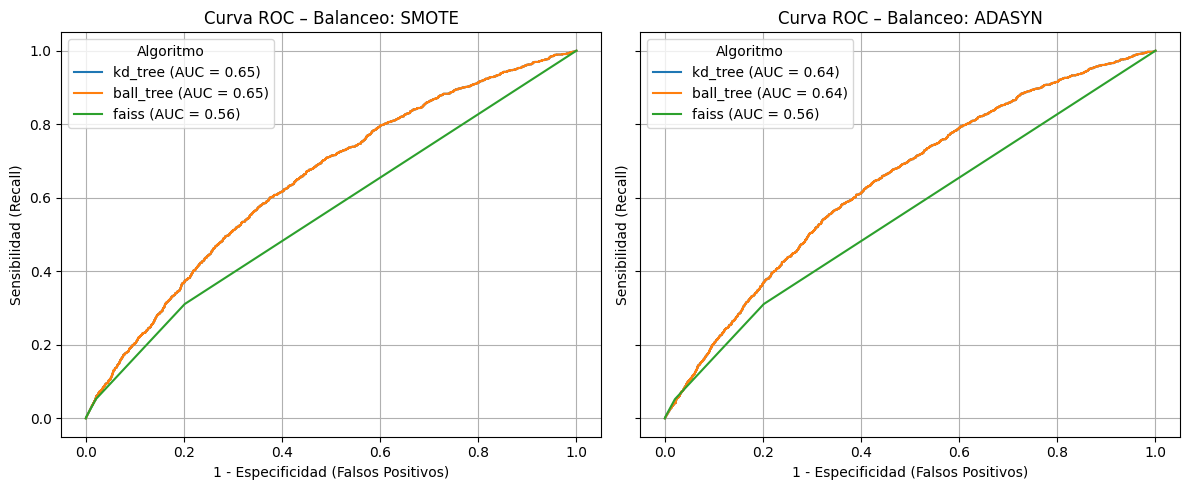

In [16]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Técnicas de balanceo y algoritmos usados
balanceos = ["SMOTE", "ADASYN"]
algoritmos = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}

# Crear figura de 1 fila × 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, bal in zip(axes, balanceos):
    for algo_key, algo_label in algoritmos.items():
        modelo_id = f"{bal}_{algo_key}"
        if modelo_id in results_completo:
            y_prob = results_completo[modelo_id]["y_prob"]
            RocCurveDisplay.from_predictions(y_test, y_prob, name=algo_label, ax=ax)

    ax.set_title(f"Curva ROC – Balanceo: {bal}")
    ax.set_xlabel("1 - Especificidad (Falsos Positivos)")
    ax.set_ylabel("Sensibilidad (Recall)")
    ax.grid(True)
    ax.legend(title="Algoritmo")

plt.tight_layout()
plt.show()


# MATRICES DE CONFUSIÓN COMPARATIVAS – SMOTE vs ADASYN × 3 ALGORITMOS

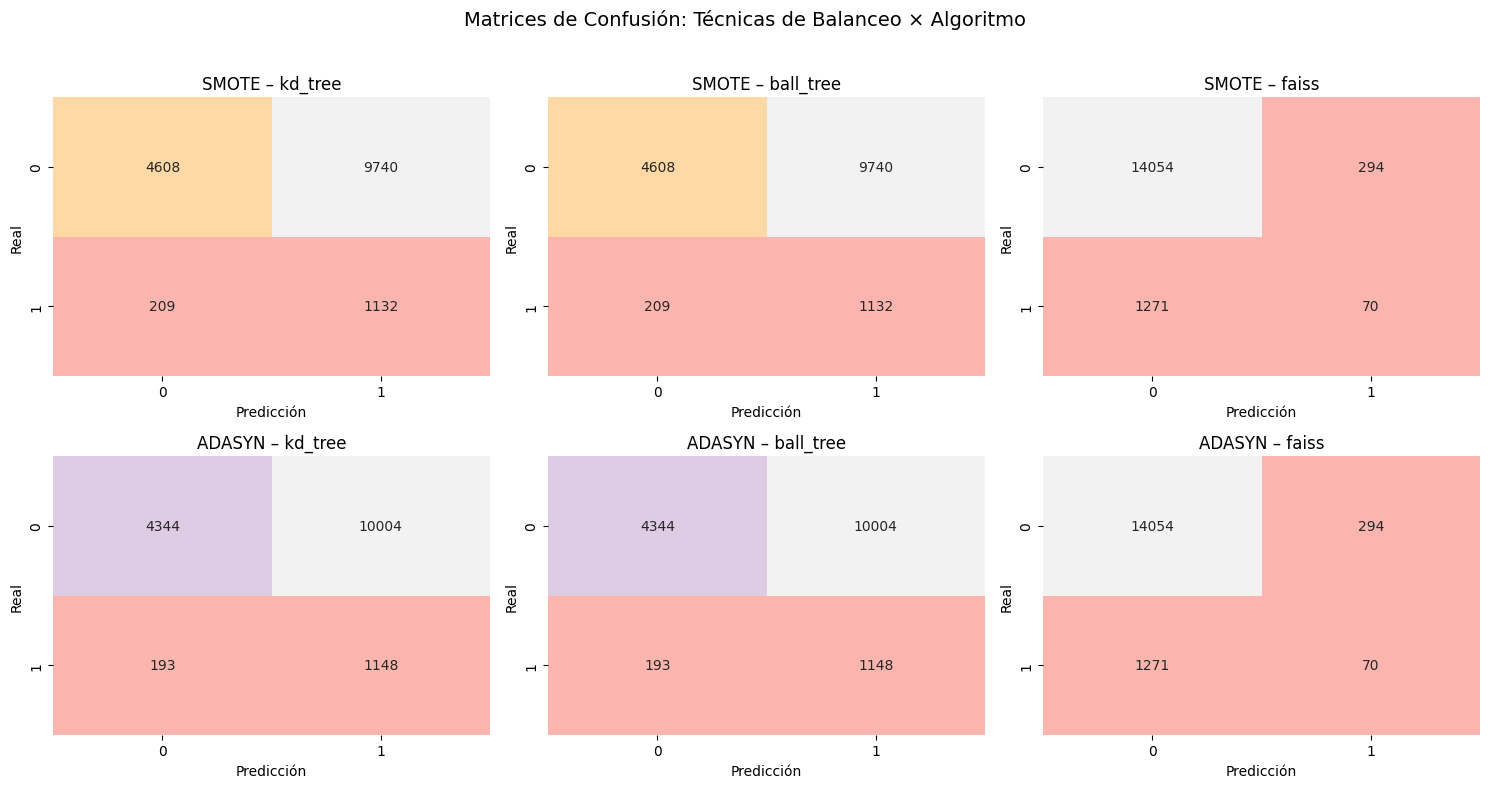

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ================================
# Configuración
# ================================
balanceos = ["SMOTE", "ADASYN"]
algoritmos = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}
colores = sns.color_palette("pastel")

# Crear figura: 2 filas (balanceo), 3 columnas (algoritmo)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

for i, bal in enumerate(balanceos):
    for j, (key_algo, algo_label) in enumerate(algoritmos.items()):
        name = f"{bal}_{key_algo}"  # ej: SMOTE_kd, ADASYN_faiss
        y_pred = results_completo[name]["y_pred"]

        cm = confusion_matrix(y_test, y_pred)

        ax = axes[i, j]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Pastel1", cbar=False, ax=ax)
        ax.set_title(f"{bal} – {algo_label}")
        ax.set_xlabel("Predicción")
        ax.set_ylabel("Real")

plt.suptitle("Matrices de Confusión: Técnicas de Balanceo × Algoritmo", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Curva de Aprendizaje

In [ ]:
# ===========================================
# 0. Imports necesarios
# ===========================================

# ===========================================
# Eliminar warnings (estéticos)
# ===========================================
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import recall_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
from copy import deepcopy
import faiss

# ===========================================
# 1. Función curva de aprendizaje FAISS
# ===========================================
def faiss_learning_curve(X_train, y_train, X_test, y_test, scaler, k, balanceador):
    sizes = np.linspace(0.2, 1.0, 5)
    recalls = []

    # Escalar y balancear
    X_scaled = scaler.fit_transform(X_train.select_dtypes(include=np.number))
    X_test_scaled = scaler.transform(X_test.select_dtypes(include=np.number))
    y_train = y_train.reset_index(drop=True)
    X_res, y_res = balanceador.fit_resample(X_scaled, y_train)

    for frac in sizes:
        n = int(len(X_res) * frac)
        X_frac = X_res[:n]
        y_frac = y_res[:n]

        index = faiss.IndexFlatL2(X_frac.shape[1])
        index.add(X_frac)

        D, I = index.search(X_test_scaled, k)
        y_pred = [int(np.sum(y_frac[i]) >= (k / 2)) for i in I]

        recall = recall_score(y_test, y_pred, zero_division=0)
        recalls.append(recall)

    return sizes, recalls

# ===========================================
# 2. Configuración base
# ===========================================
balanceadores = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42)
}

algoritmos = {
    "kd": "kd_tree",
    "ball": "ball_tree",
    "faiss": "faiss"
}

colores = {
    "kd_tree": "steelblue",
    "ball_tree": "mediumorchid",
    "faiss": "darkorange"
}

train_sizes = np.linspace(0.2, 1.0, 5)

# ===========================================
# 3. Graficar curvas de aprendizaje
# ===========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, (bal_nombre, balanceador) in zip(axes, balanceadores.items()):
    for algo_key, algo_label in algoritmos.items():
        modelo_id = f"{bal_nombre}_{algo_key}"
        k_opt = results_completo[modelo_id]["best_params"].get("clf__n_neighbors") or \
                results_completo[modelo_id]["best_params"].get("k")

        if algo_key == "faiss":
            sizes_faiss, recalls_faiss = faiss_learning_curve(
                X_train, y_train, X_test, y_test,
                scaler=StandardScaler(),
                k=k_opt,
                balanceador=deepcopy(balanceador)
            )
            ax.plot(sizes_faiss * 100, recalls_faiss,
                    marker="o", linestyle="--", label="faiss", color=colores["faiss"])
        else:
            pipe = ImbPipeline([
                ("pre", deepcopy(preprocessor)),
                ("over", deepcopy(balanceador)),
                ("clf", KNeighborsClassifier(
                    algorithm=algo_label,
                    n_neighbors=k_opt
                ))
            ])
            sizes, _, scores = learning_curve(
                pipe, X_train, y_train,
                train_sizes=train_sizes,
                cv=3,
                scoring=make_scorer(recall_score, pos_label=1),
                n_jobs=-1
            )
            ax.plot(sizes / len(X_train) * 100, np.mean(scores, axis=1),
                    marker="o", label=algo_label, color=colores[algo_label])

    ax.set_title(f"Curva de Aprendizaje – {bal_nombre}")
    ax.set_xlabel("Tamaño del set de entrenamiento (%)")
    ax.set_ylabel("Recall clase 1")
    ax.grid(True)
    ax.legend(title="Algoritmo")

plt.suptitle("Comparación de Curvas de Aprendizaje por Técnica de Balanceo y Algoritmo", fontsize=14)
plt.tight_layout()
plt.show()


# Gráfico de barras de métricas por modelo

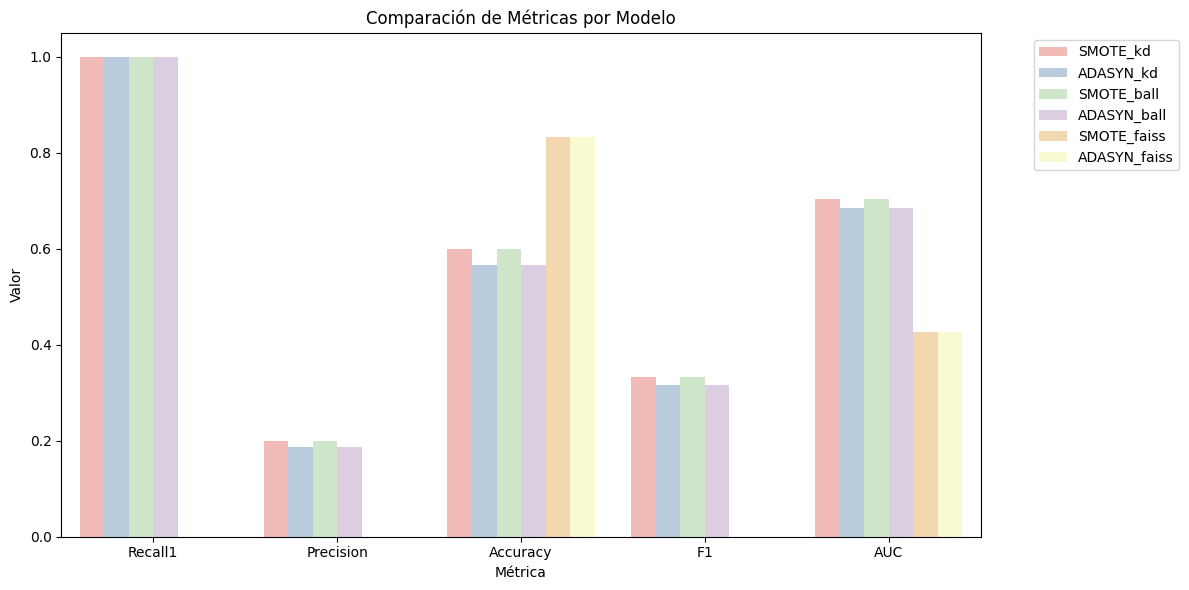

In [ ]:
# Seleccionamos las métricas de resultados_completo
df_plot = pd.DataFrame({
    k: {
        "Recall1": v["Recall1"],
        "Precision": v["Precision"],
        "Accuracy": v["Accuracy"],
        "F1": v["F1"],
        "AUC": v["AUC"]
    }
    for k, v in results_completo.items()
}).T.reset_index().rename(columns={"index": "Modelo"})

# Convertimos a formato largo (long-form) para seaborn
df_melt = df_plot.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_melt,
    x="Métrica", y="Valor", hue="Modelo",
    palette=sns.color_palette("Pastel1"))
plt.title("Comparación de Métricas por Modelo")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
import faiss
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    f1_score, roc_auc_score
)

# Paso 1: Solo numéricas y escaladas
X_tr = StandardScaler().fit_transform(X_train.select_dtypes(include=np.number))
X_te = StandardScaler().fit_transform(X_test.select_dtypes(include=np.number))
y_tr = y_train.reset_index(drop=True)

# Paso 2: Crear índice FAISS
index = faiss.IndexFlatL2(X_tr.shape[1])
index.add(X_tr)

# Valores de k a probar
k_values = [3, 5, 10, 15, 20]
faiss_results = {}

for k in k_values:
    D, I = index.search(X_te, k)

    y_pred = [int(np.sum(y_tr.iloc[vecinos]) >= (k / 2)) for vecinos in I]
    y_prob = [np.mean(y_tr.iloc[vecinos]) for vecinos in I]

    faiss_results[k] = {
        "k": k,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall1": recall_score(y_test, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_test, y_prob)
    }

# Encontrar mejor k (por Recall1)
best_k = max(faiss_results, key=lambda k: faiss_results[k]["Recall1"])
best_res = faiss_results[best_k]

# Guardar en results principal
results["FAISS"] = {
    "best_params": {"k": best_k, "distance": "L2"},
    "estimator": f"faiss_manual_k={best_k}",
    "y_pred": np.array(best_res["y_pred"]),
    "y_prob": np.array(best_res["y_prob"]),
    "fit_minutes": 0,
    "Precision": best_res["Precision"],
    "Recall1": best_res["Recall1"],
    "Accuracy": best_res["Accuracy"],
    "F1": best_res["F1"],
    "AUC": best_res["AUC"]
}

# Heatmap de Recall1 agrupado por algoritmo y técnica de balanceo

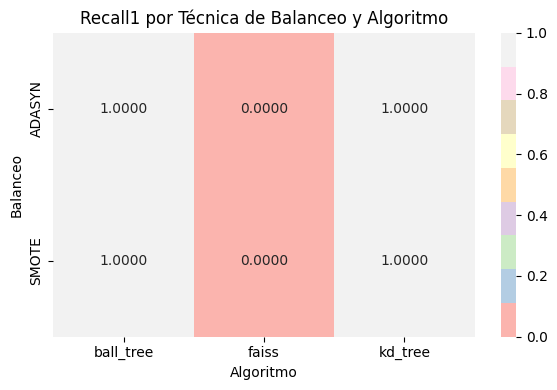

In [ ]:
# Crear DataFrame de comparación
df_heat = []
for name, res in results_completo.items():
    balanceo, algoritmo_key = name.split("_")
    algoritmo = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}[algoritmo_key]
    df_heat.append((balanceo, algoritmo, res["Recall1"]))

df_heat = pd.DataFrame(df_heat, columns=["Balanceo", "Algoritmo", "Recall1"])
heatmap_data = df_heat.pivot(index="Balanceo", columns="Algoritmo", values="Recall1")

plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="Pastel1")
plt.title("Recall1 por Técnica de Balanceo y Algoritmo")
plt.tight_layout()
plt.show()


# Gráfico de tiempo de cómputo por modelo

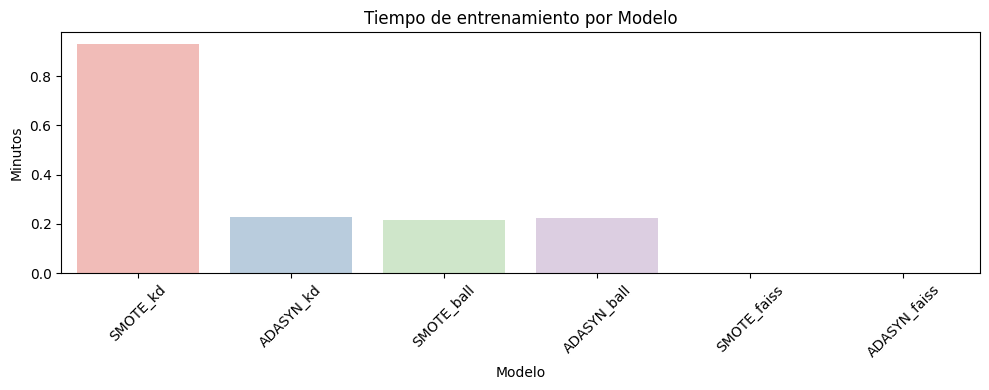

In [ ]:
# Crear tabla de tiempos de entrenamiento
df_time = pd.DataFrame({
    k: {"Tiempo": v["fit_minutes"]} for k, v in results_completo.items()
}).T.reset_index().rename(columns={"index": "Modelo"})


plt.figure(figsize=(10, 4))
sns.barplot(data=df_time, x="Modelo", y="Tiempo", palette="Pastel1")
plt.xticks(rotation=45)
plt.title("Tiempo de entrenamiento por Modelo")
plt.ylabel("Minutos")
plt.tight_layout()
plt.show()


# Curvas Precision–Recall (por técnica de balanceo)

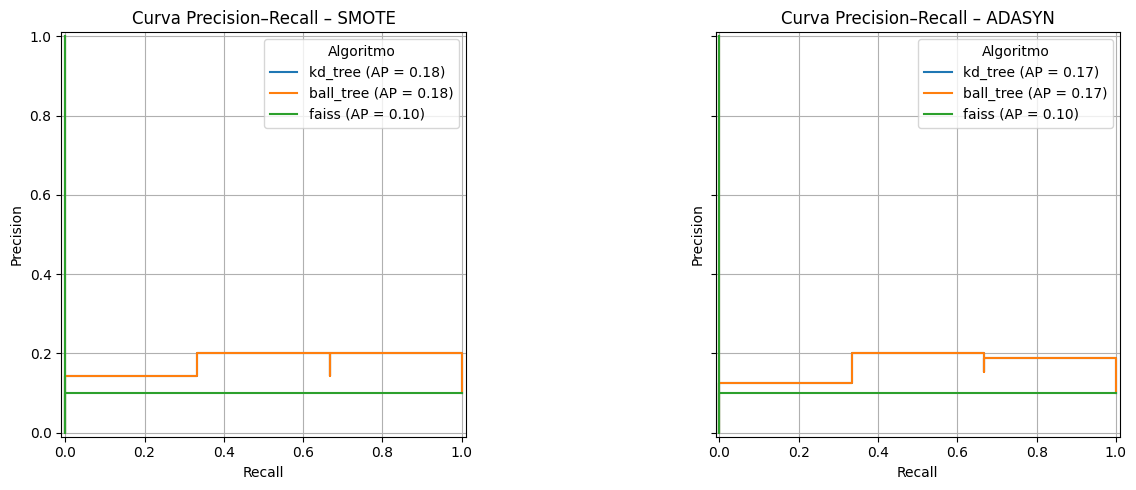

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

# Crear 1 curva por técnica de balanceo, comparando algoritmos
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
balanceos = ["SMOTE", "ADASYN"]
algoritmos = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}

for ax, bal in zip(axes, balanceos):
    for algo_key, algo_label in algoritmos.items():
        modelo_id = f"{bal}_{algo_key}"
        if modelo_id in results_completo:
            y_prob = results_completo[modelo_id]["y_prob"]
            PrecisionRecallDisplay.from_predictions(
                y_test, y_prob, name=algo_label, ax=ax
            )

    ax.set_title(f"Curva Precision–Recall – {bal}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(title="Algoritmo")
    ax.grid(True)

plt.tight_layout()
plt.show()


# Radar Plot (por modelo) – Comparar todas las métricas

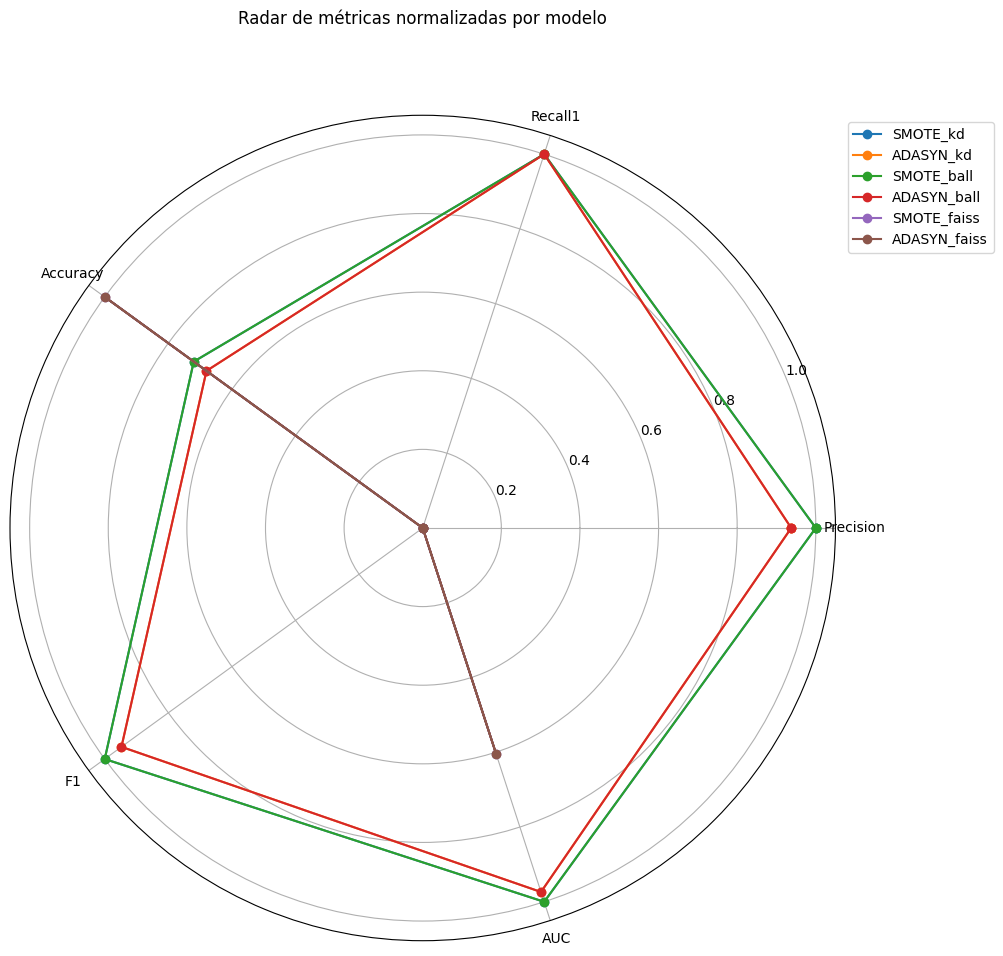

In [ ]:
from math import pi

# Métricas a graficar
metricas = ["Precision", "Recall1", "Accuracy", "F1", "AUC"]

# Preparar datos
df_radar = pd.DataFrame({
    k: [v[m] for m in metricas]
    for k, v in results_completo.items()
}, index=metricas).T

# Normalizar para que escalen igual (opcional, visualmente más claro)
df_norm = df_radar / df_radar.max()

# Graficar
plt.figure(figsize=(10, 10))
labels = metricas
num_vars = len(labels)

for modelo in df_norm.index:
    values = df_norm.loc[modelo].tolist()
    values += values[:1]  # cerrar el círculo

    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    plt.polar(angles, values, marker='o', label=modelo)

plt.xticks([n / float(num_vars) * 2 * pi for n in range(num_vars)], labels)
plt.title("Radar de métricas normalizadas por modelo", y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()


# Boxplot de métricas por algoritmo

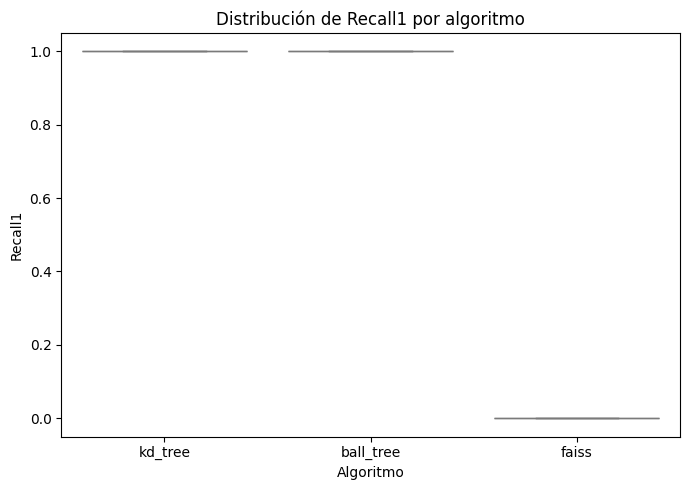

In [ ]:
df_box = []

for name, res in results_completo.items():
    balanceo, algoritmo_key = name.split("_")
    algoritmo = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}[algoritmo_key]
    df_box.append({"Algoritmo": algoritmo, "Recall1": res["Recall1"]})

df_box = pd.DataFrame(df_box)

plt.figure(figsize=(7, 5))
sns.boxplot(data=df_box, x="Algoritmo", y="Recall1", palette="Pastel1")
plt.title("Distribución de Recall1 por algoritmo")
plt.tight_layout()
plt.show()


In [ ]:
# Unir todos los resultados
results_completo = {
    **results_kd,
    **results_bt,
    "SMOTE_faiss": results["SMOTE_faiss"],
    "ADASYN_faiss": results["ADASYN_faiss"]
}

# Extraer parámetros óptimos
rows = []
for name, res in results_completo.items():
    balanceo, algoritmo_key = name.split("_")
    algoritmo = {"kd": "kd_tree", "ball": "ball_tree", "faiss": "faiss"}[algoritmo_key]
    params = res.get("best_params", {})

    rows.append({
        "Balanceo": balanceo,
        "Algoritmo": algoritmo,
        "k": params.get("clf__n_neighbors", params.get("k", "–")),
        "Weights": params.get("clf__weights", "–"),
        "Leaf Size": params.get("clf__leaf_size", "–"),
        "Algoritmo Interno": params.get("clf__algorithm", "–")
    })

df_params = pd.DataFrame(rows).sort_values(["Balanceo", "Algoritmo"]).set_index(["Balanceo", "Algoritmo"])


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Reemplazar "–" por np.nan temporalmente para el estilo
df_params_styled = df_params.replace("–", np.nan)

# Función de estilo para nulos
def highlight_missing(val):
    return 'background-color: lightgray' if pd.isnull(val) else ''

# Estilo con map() (nuevo estándar)
styled_params = (
    df_params_styled.style
        .map(highlight_missing)
        .set_caption("Hiperparámetros Óptimos por Técnica de Balanceo y Algoritmo")
)

display(styled_params)


In [ ]:
import joblib
import os

# Crear carpeta local (dentro de /content o proyecto VSCode)
ruta_modelos = "./modelos_knn"
os.makedirs(ruta_modelos, exist_ok=True)

# Recorrer y guardar modelos
for nombre, res in results_completo.items():
    modelo = res["estimator"]
    nombre_archivo = f"{nombre}_KNN.pkl"
    ruta_completa = os.path.join(ruta_modelos, nombre_archivo)

    try:
        joblib.dump(modelo, ruta_completa)
        print(f"✅ Guardado: {ruta_completa}")
    except Exception as e:
        print(f"❌ Error al guardar {nombre}: {e}")


✅ Guardado: ./modelos_knn/SMOTE_kd_KNN.pkl
✅ Guardado: ./modelos_knn/ADASYN_kd_KNN.pkl
✅ Guardado: ./modelos_knn/SMOTE_ball_KNN.pkl
✅ Guardado: ./modelos_knn/ADASYN_ball_KNN.pkl
✅ Guardado: ./modelos_knn/SMOTE_faiss_KNN.pkl
✅ Guardado: ./modelos_knn/ADASYN_faiss_KNN.pkl
